# **Redes Convolucionales**



## Configuración del entorno en colab

In [ ]:
import tensorflow as tf

# Detectar y inicializar la TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detectar la TPU
    print('Se ha detectado la TPU')
except ValueError:
    raise BaseException('No se ha detectado ninguna TPU')

# Conectar y inicializar el sistema TPU
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
print('Sistema TPU inicializado')

BaseException: No se ha detectado ninguna TPU

In [ ]:
# Crear la estrategia de distribución TPU
strategy = tf.distribute.TPUStrategy(tpu)


NameError: name 'tpu' is not defined

## Importando los datos y revisando el problema

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
# Cargar el dataset de perros y gatos
(raw_train, raw_validation), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:95%]', 'train[95%:]'],
    with_info=True,
    as_supervised=True,
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.DTB2RN_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


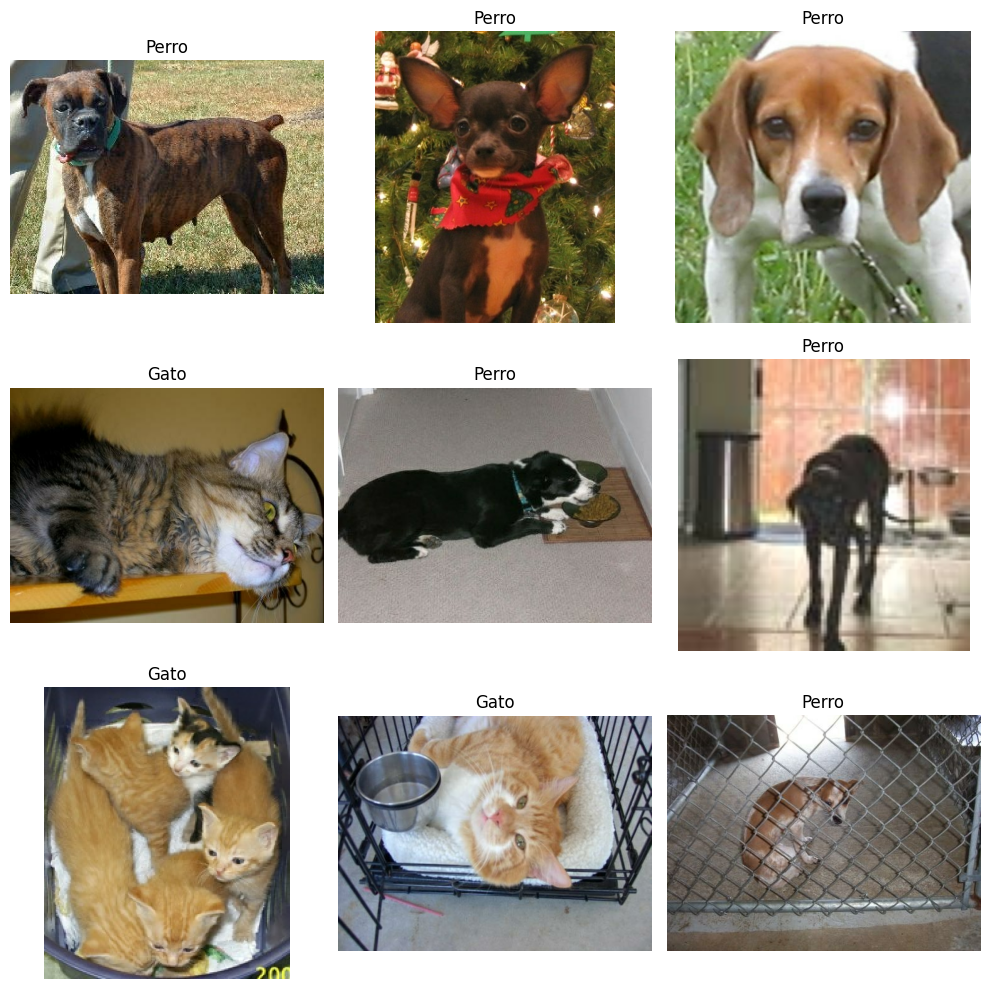

In [ ]:
# Función para mostrar imágenes con sus etiquetas
def show_images(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        label_text = 'Perro' if label.numpy() == 1 else 'Gato'
        plt.title(label_text)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Mostrar 9 imágenes del conjunto de entrenamiento
show_images(raw_train, 9)


## Procesamiento

In [ ]:
IMG_SIZE = 150

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalizar los píxeles entre 0 y 1
    return image, label


In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)


In [ ]:
# Ajustar el tamaño de lote
#BATCH_SIZE = 128 * strategy.num_replicas_in_sync  # num_replicas_in_sync generalmente es 8 en TPUs
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

# Aplicar el tamaño de lote y prefetch
train_batches = train.cache().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)
validation_batches = validation.cache().batch(BATCH_SIZE).prefetch(AUTO)


In [ ]:
#with strategy.scope():
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),  # Añadimos Flatten aquí

    layers.Dense(512, activation='relu'),  # Capa densa completamente conectada

    layers.Dense(1024, activation='tanh'),  # Capa densa completamente conectada

    layers.Dense(512, activation='relu'),  # Capa densa completamente conectada

    layers.Dense(1024, activation='tanh'),  # Capa densa completamente conectada

    layers.Dense(512, activation='relu'),  # Capa densa completamente conectada

    layers.Dense(1, activation='sigmoid')  # Capa de salida
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,046,849 (11.62 MB)

 Trainable params: 3,046,849 (11.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 10

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches
)


Epoch 1/10
 66/173 ━━━━━━━━━━━━━━━━━━━━ 12:36 7s/step - accuracy: 0.5083 - loss: 0.7015

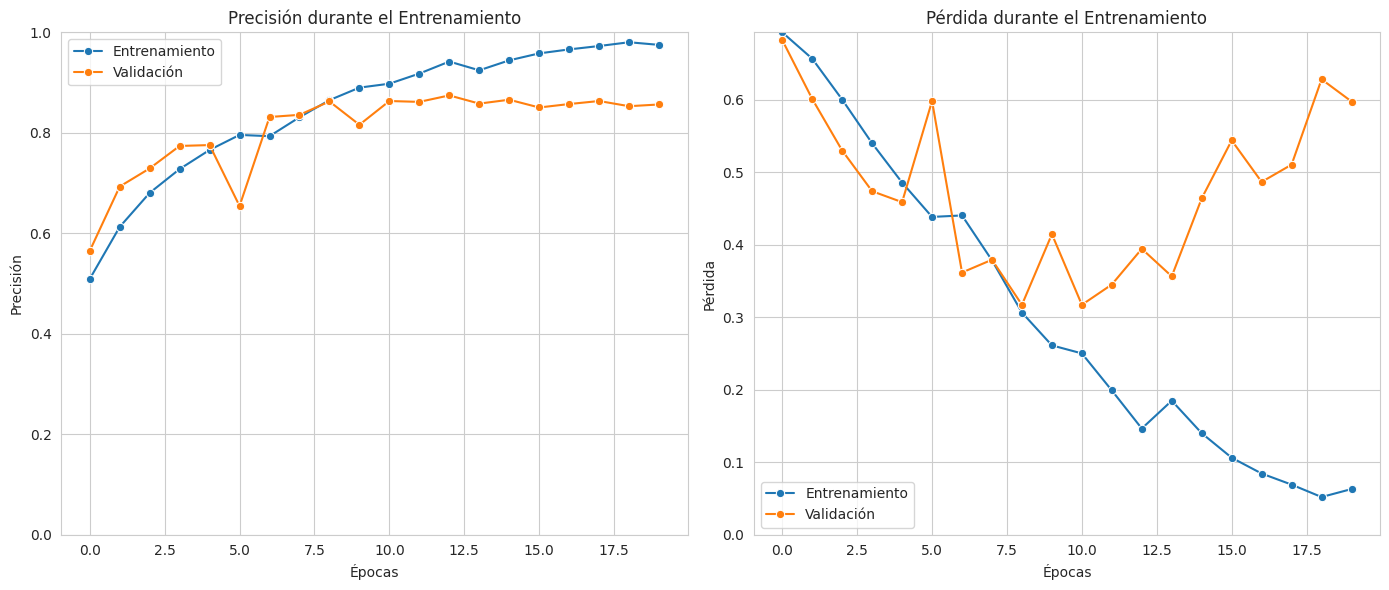

In [ ]:
# Gráficos de precisión y pérdida mejorados
import pandas as pd

# Convertir el historial en un DataFrame
history_df = pd.DataFrame(history.history)

# Añadir la columna de épocas
history_df['Epoch'] = history.epoch

# Configurar estilos de Seaborn
sns.set_style('whitegrid')

# Gráfico de Precisión
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=history_df, x='Epoch', y='accuracy', label='Entrenamiento', marker='o')
sns.lineplot(data=history_df, x='Epoch', y='val_accuracy', label='Validación', marker='o')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.ylim(0, 1)

# Gráfico de Pérdida
plt.subplot(1, 2, 2)
sns.lineplot(data=history_df, x='Epoch', y='loss', label='Entrenamiento', marker='o')
sns.lineplot(data=history_df, x='Epoch', y='val_loss', label='Validación', marker='o')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.ylim(0, max(history_df['loss'].max(), history_df['val_loss'].max()))

plt.tight_layout()
plt.show()


In [ ]:
# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(validation_batches)
print(f'Precisión en validación: {val_accuracy * 100:.2f}%')


2/2 [==============================] - 1s 191ms/step - loss: 0.5974 - accuracy: 0.8564
Precisión en validación: 85.64%


5/5 [==============================] - 6s 491ms/step
Reporte de Clasificación:
              precision    recall  f1-score   support

        Gato       0.90      0.80      0.85       584
       Perro       0.82      0.91      0.86       579

    accuracy                           0.86      1163
   macro avg       0.86      0.86      0.86      1163
weighted avg       0.86      0.86      0.86      1163



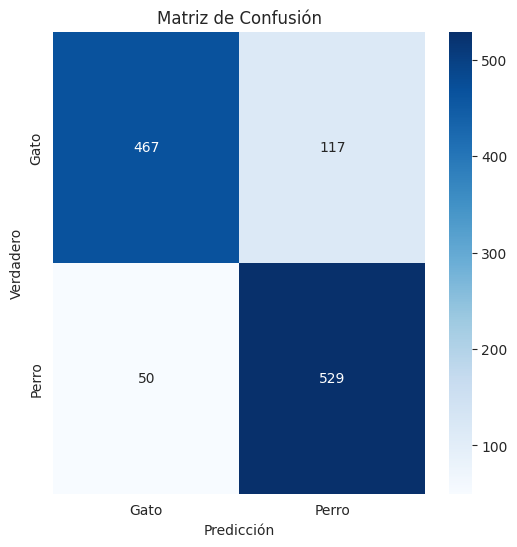

In [ ]:
# Obtener predicciones
y_pred = []
y_true = []

for images, labels in validation_batches:
    preds = model.predict(images)
    y_pred.extend(np.round(preds).astype(int).flatten())
    y_true.extend(labels.numpy())

# Reporte de clasificación
print('Reporte de Clasificación:')
print(classification_report(y_true, y_pred, target_names=['Gato', 'Perro']))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gato', 'Perro'], yticklabels=['Gato', 'Perro'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()


1/1 [==============================] - 0s 406ms/step


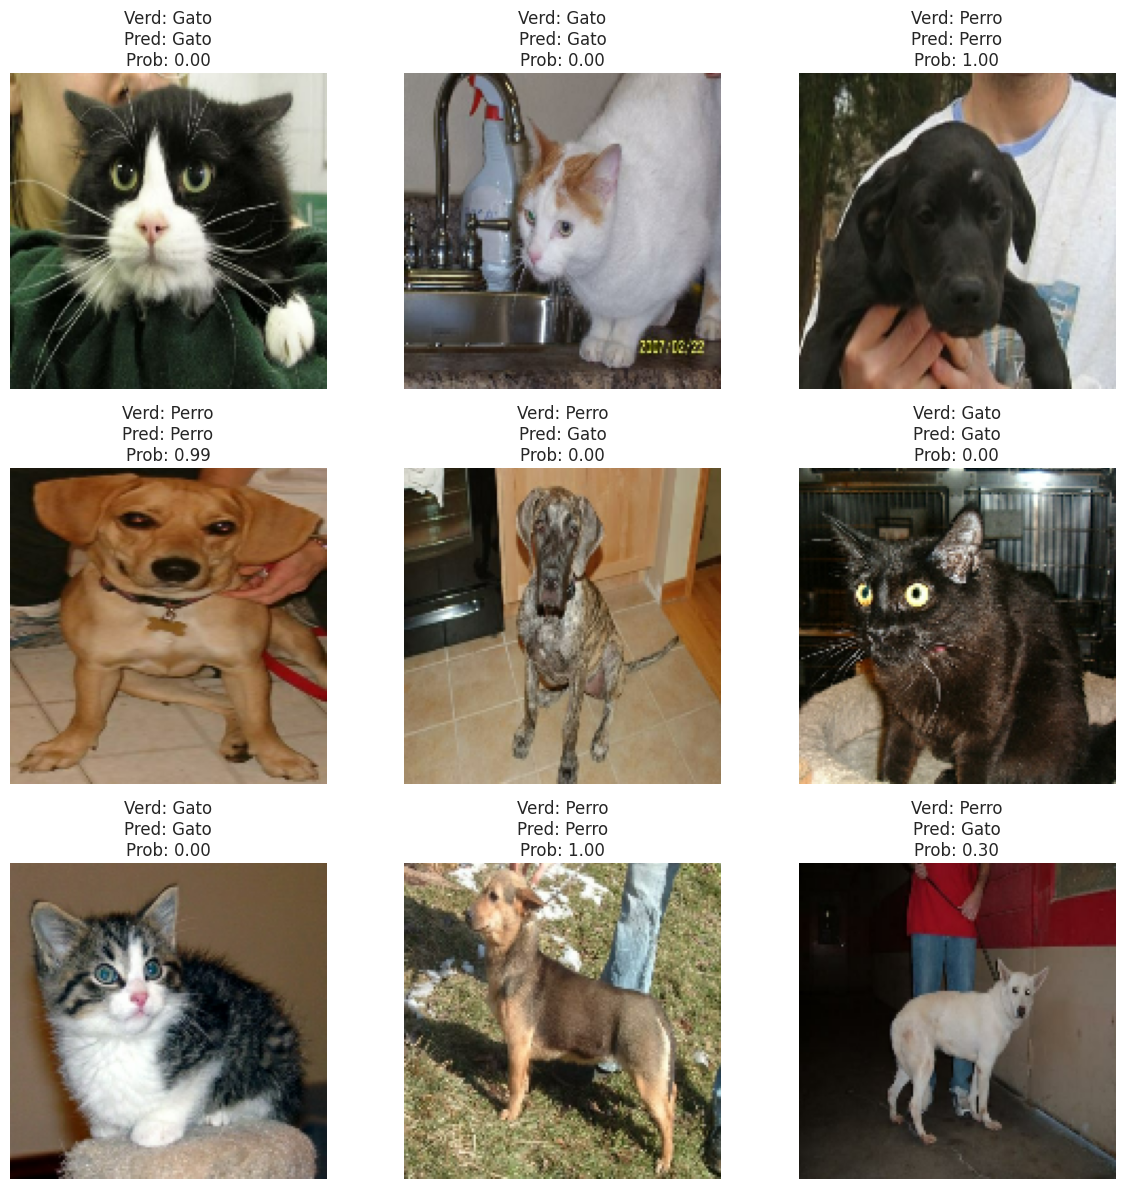

In [ ]:
# Mostrar algunas imágenes con sus predicciones
plt.figure(figsize=(12, 12))
for images, labels in validation_batches.take(1):
    for i in range(9):
        img = images[i].numpy()
        true_label = 'Perro' if labels[i].numpy() == 1 else 'Gato'
        pred_prob = model.predict(tf.expand_dims(images[i], axis=0))[0][0]
        pred_label = 'Perro' if pred_prob > 0.5 else 'Gato'
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(f'Verd: {true_label}\nPred: {pred_label}\nProb: {pred_prob:.2f}')
        plt.axis('off')
plt.tight_layout()
plt.show()
